data: willhaben: apartments for sale in vienna (no other filters)

In [145]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
%matplotlib inline
pd.options.display.float_format = '{:.0f}'.format


files = (Path.cwd() / "data").iterdir()
files = sorted(files, key=lambda x: x.name)
file = files[-1]
print(f"reading {file}")
df = pd.read_csv(file, delimiter=";")


def clean_up(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=["link", "title"])

    df["postal"] = df["address"].str.extract(r"(\d{4})").replace(np.nan, 0).astype(int)
    df = df.drop(columns=["address"])

    df["price"] = df["price"].str.replace(r"[^\d.,]", "", regex=True) # only keep numbers, point and comma
    df["price"] = df["price"].str.replace(r"\.", "", regex=True) # remove thousand separator
    df["price"] = df["price"].str.replace(r",", ".", regex=True) # convert comma to point
    df["price"] = df["price"].astype(float)

    df["m2"] = df["m2"].str.extract(r"(\d+)").astype(float)

    df["num_rooms"] = df["num_rooms"].str.extract(r"(\d+)").astype(float)

    df["type"] = df["type"].str.lower()

    return df


df = clean_up(df)
df.head()

reading /Users/sueszli/dev/will-wohnen/data/links_2024-05-25_14-46-15.csv


,price,m2,num_rooms,type,postal
0,425000,67,3,balkon,1210
1,284900,86,3,garten,1210
2,439000,76,3,NaN,1200
3,1300000,115,3,"terrasse, balkon",1070
4,249000,55,2,NaN,1020


# summary stats

In [146]:
print(f"""
total: {len(df)}
------------------------
{df["price"].describe()}
------------------------
{df["m2"].describe()}
------------------------
{df["num_rooms"].describe()}
""")


total: 9978
------------------------
count       9817
mean      576411
std       742731
min            1
25%       297002
50%       399000
75%       590000
max     15900000
Name: price, dtype: float64
------------------------
count   9588
mean      75
std       48
min        2
25%       48
50%       65
75%       86
max      870
Name: m2, dtype: float64
------------------------
count   9346
mean       3
std        1
min        1
25%        2
50%        2
75%        3
max       27
Name: num_rooms, dtype: float64



# plots

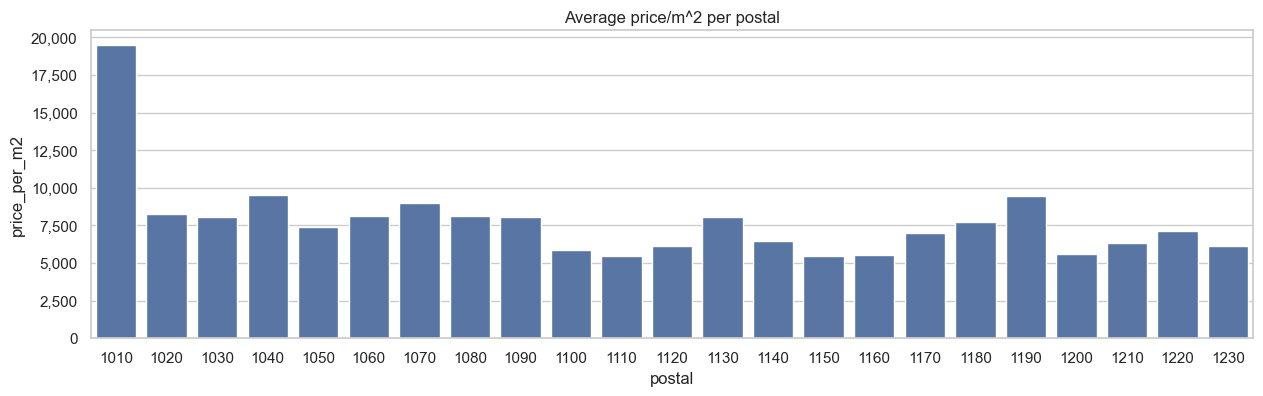

ranking:
1. 1010.0: 19507
4. 1040.0: 9547
19. 1190.0: 9453
7. 1070.0: 9005
2. 1020.0: 8252
8. 1080.0: 8146
6. 1060.0: 8107
9. 1090.0: 8087
3. 1030.0: 8084
13. 1130.0: 8070
18. 1180.0: 7747
5. 1050.0: 7401
22. 1220.0: 7097
17. 1170.0: 6972
14. 1140.0: 6464
21. 1210.0: 6334
12. 1120.0: 6136
23. 1230.0: 6109
10. 1100.0: 5844
20. 1200.0: 5631
16. 1160.0: 5551
15. 1150.0: 5493
11. 1110.0: 5490


In [179]:
copy = df.copy()
copy["price_per_m2"] = copy["price"] / copy["m2"]

copy = copy[copy["postal"] != 0]
copy = copy.groupby("postal")["price_per_m2"].mean().reset_index()
copy = copy.sort_values(by="price_per_m2", ascending=False)

plt.figure(figsize=(15, 4))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

sns.barplot(x="postal", y="price_per_m2", data=copy)
plt.title("Average price/m^2 per postal")
plt.show()

# print order of postal codes
print("ranking:")
for i, row in copy.iterrows():
    print(f"{i+1}. {row['postal']}: {row['price_per_m2']:.0f}")

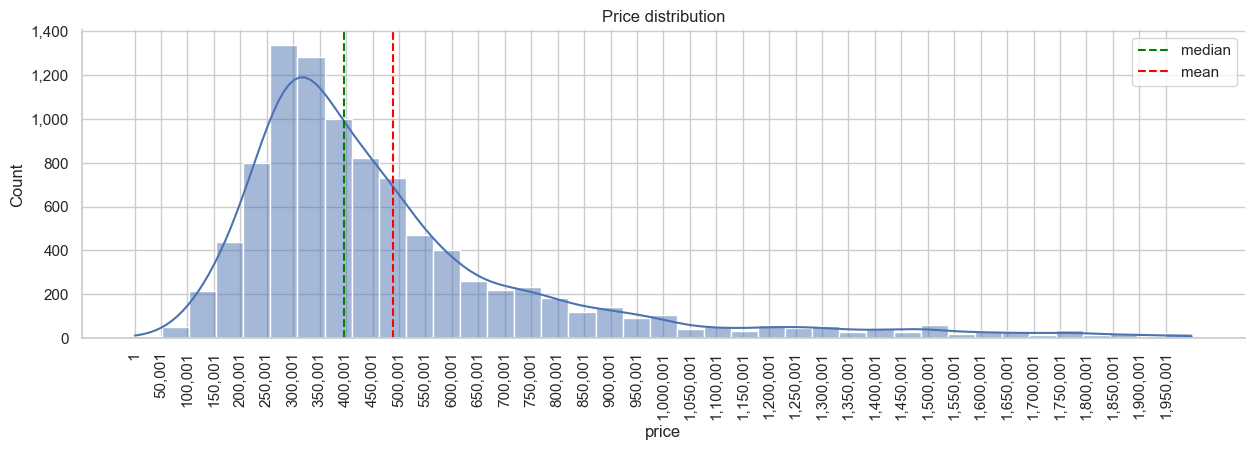

In [173]:
copy = df.copy()

# remove outliers
minval = copy["price"].min()
maxval = 2_000_000
copy = copy[copy["price"] > minval]
copy = copy[copy["price"] < maxval]

# set step size
step = 50_000
num_buckets = int((maxval - minval) // step)

plt.figure(figsize=(15, 4))
sns.histplot(copy["price"], bins=num_buckets, kde=True)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.xticks(np.arange(minval, maxval, step), rotation=90)
plt.title("Price distribution")

sns.despine(left=True)
sns.despine(top=True)

plt.axvline(copy["price"].median(), color="green", linestyle="--", label="median")
plt.axvline(copy["price"].mean(), color="red", linestyle="--", label="mean")
plt.legend(loc='upper right')
plt.show()

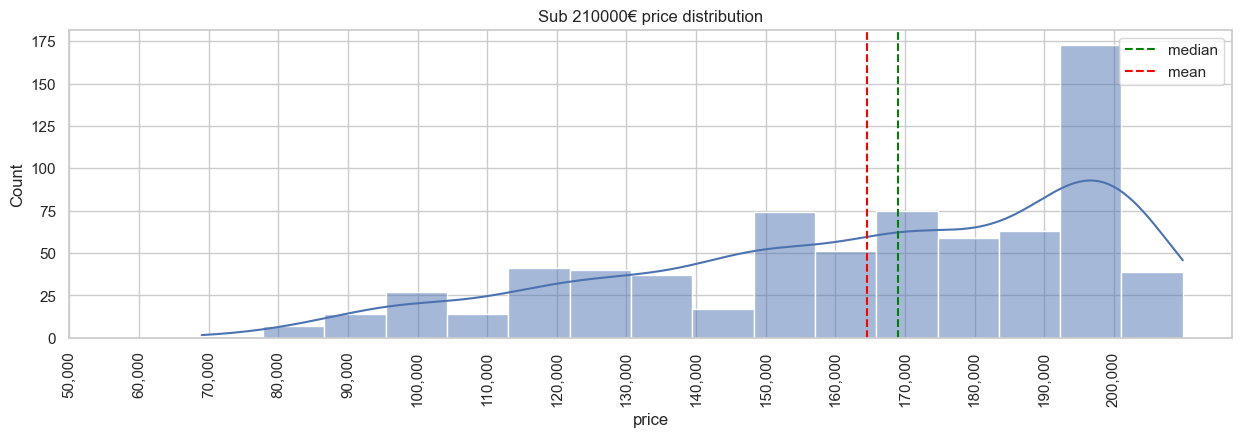

In [163]:
copy = df.copy()

# remove outliers
minval = 50_000
maxval = 210_000
copy = copy[copy["price"] > minval]
copy = copy[copy["price"] < maxval]

# set step size
step = 10_000
num_buckets = int((maxval - minval) // step)

plt.figure(figsize=(15, 4))
sns.histplot(copy["price"], bins=num_buckets, kde=True)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.xticks(np.arange(minval, maxval, step), rotation=90)
plt.title(f"Sub {maxval}€ price distribution")

plt.axvline(copy["price"].median(), color="green", linestyle="--", label="median")
plt.axvline(copy["price"].mean(), color="red", linestyle="--", label="mean")
plt.legend(loc='upper right')
plt.show()